## Introduction

In this notebook, we will show how to build a protein patch GNN using the software library we have built.

## Loading proteins as graph objects in memory

The first thing we do is to load a PDB file into memory as a NetworkX graph object. The tool that we use is called `proteingraph`, and is installable directly from PyPI. The next generation version of `proteingraph` is called `graphein`, and is designed to handle the conversion of multiple types of biological data into its graph representation.

In any case, to load a PDB file of a protein structure into a NetworkX graph object, we use the `read_pdb` function from `proteingraph`.

In [1]:
from proteingraph import read_pdb
from pyprojroot import here

hiv_graph = read_pdb(here() / "data/hiv1_homology_model.pdb")
hiv_graph

`hiv_graph` is a NetworkX graph object, as you can see from above, and as such will work with the NetworkX API seamlessly.

In [2]:
hiv_graph.nodes()

NodeView(('A10PHE', 'A11VAL', 'A12THR', 'A13ILE', 'A14LYS', 'A15ILE', 'A16GLY', 'A17GLY', 'A18GLN', 'A19LEU', 'A1PRO', 'A20LYS', 'A21GLU', 'A22ALA', 'A23LEU', 'A24LEU', 'A25ASP', 'A26THR', 'A27GLY', 'A28ALA', 'A29ASP', 'A2GLN', 'A30ASP', 'A31THR', 'A32ILE', 'A33PHE', 'A34GLN', 'A35GLU', 'A36MET', 'A37HIS', 'A38LEU', 'A39PRO', 'A3ILE', 'A40GLY', 'A41LYS', 'A42TRP', 'A43LYS', 'A44PRO', 'A45LYS', 'A46ILE', 'A47VAL', 'A48GLY', 'A49GLY', 'A4THR', 'A50ILE', 'A51GLY', 'A52GLY', 'A53LEU', 'A54LEU', 'A55ARG', 'A56VAL', 'A57LYS', 'A58GLU', 'A59TYR', 'A5LEU', 'A60GLU', 'A61GLN', 'A62ILE', 'A63PRO', 'A64ILE', 'A65GLU', 'A66ILE', 'A67CYS', 'A68GLY', 'A69HIS', 'A6TRP', 'A70LYS', 'A71VAL', 'A72ILE', 'A73GLY', 'A74THR', 'A75VAL', 'A76LEU', 'A77VAL', 'A78GLY', 'A79PRO', 'A7GLN', 'A80THR', 'A81PRO', 'A82ALA', 'A83ASN', 'A84ILE', 'A85ILE', 'A86GLY', 'A87ARG', 'A88ASN', 'A89LEU', 'A8ARG', 'A90MET', 'A91THR', 'A92GLN', 'A93ILE', 'A94GLY', 'A95CYS', 'A96THR', 'A97LEU', 'A98ASN', 'A99PHE', 'A9PRO', 'B10PHE',

## Generating protein patches from a NetworkX graph object

Our `patch_gnn` package contains the functions necessary to generate graph "patches" from a graph. Basically, these graph patches are subgraphs of the larger protein graph, and are defined for a radius around every amino acid in the graph.

In [3]:
from patch_gnn.graph import generate_patches
graph_patches = generate_patches(hiv_graph, 3)

We can visulaize a few of them to see what they look like.

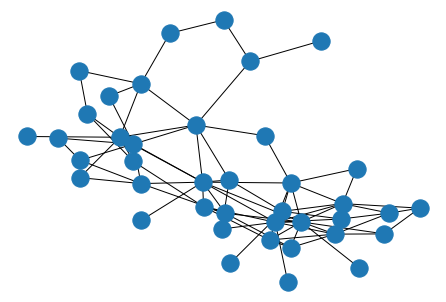

In [4]:
import networkx as nx

nx.draw(graph_patches[0])

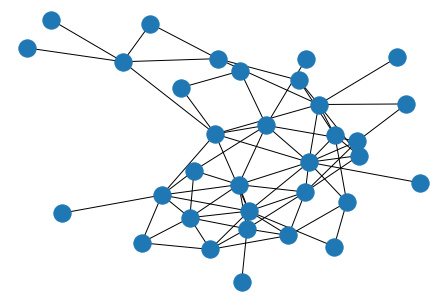

In [5]:
nx.draw(graph_patches[-10])

In [6]:
A = graph_patches[0] # get the first graph
A.nodes() # get all nodes from the first graph
A.nodes['A33PHE'] # get the attibute from the first node

{'chain_id': 'A',
 'residue_number': 33,
 'residue_name': 'PHE',
 'x_coord': 0.499,
 'y_coord': 20.529,
 'z_coord': 0.714,
 'features': None}

In [7]:
max((len(g)) for g in graph_patches) # the actual num of col is this num +1, see F = prep_features(F, max_length + 1) from graph.py

79

In [8]:
len(graph_patches)

198

## Converting the graph object into array format

Data preparation is key for us to be able to use the neural network layers defined in `patch_gnn`. In particular, we need to be able to describe amino acids according to numerical molecular descriptors. This will give us the "node feature" matrix that exists for each patch.

### EXPASY molecular descriptors

We have downloaded molecular descriptors from EXPASY, which gives us a large table of 61 descriptors for each of the 20 standard amino acids. From this, we will generate a "node feature matrix", in which each row is one amino acid in the protein patch, and each column is a particular molecular descriptor.

In [9]:
import pandas as pd
aa_feats = pd.read_csv(here() / "data/amino_acid_properties.csv", index_col=0)
aa_feats

,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
pka_cooh_alpha,2.35,2.18,2.18,1.88,1.71,2.17,2.19,2.34,1.78,2.32,2.36,2.20,2.28,2.58,1.99,2.21,2.15,2.38,2.20,2.29
pka_nh3,9.87,9.09,9.09,9.60,10.78,9.13,9.67,9.60,8.97,9.76,9.60,8.90,9.21,9.24,10.60,9.15,9.12,9.39,9.11,9.74
pka_rgroup,7.00,13.20,13.20,3.65,8.33,7.00,4.25,7.00,5.97,7.00,7.00,10.28,7.00,7.00,7.00,7.00,7.00,7.00,10.07,7.00
isoelectric_points,6.11,10.76,10.76,2.98,5.02,5.65,3.08,6.06,7.64,6.04,6.04,9.47,5.74,5.91,6.30,5.68,5.60,5.88,5.63,6.02
molecularweight,89.00,174.00,132.00,133.00,121.00,146.00,147.00,75.00,155.00,131.00,131.00,146.00,149.00,165.00,115.00,105.00,119.00,204.00,181.00,117.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
antiparallelbeta_strand,0.90,1.02,0.62,0.47,1.24,1.18,0.62,0.56,1.12,1.54,1.26,0.74,1.09,1.23,0.42,0.87,1.30,1.75,1.68,1.53
parallelbeta_strand,1.00,0.68,0.54,0.50,0.91,0.28,0.59,0.79,0.38,2.60,1.42,0.59,1.49,1.30,0.35,0.70,0.59,0.89,1.08,2.63
a_a_composition,8.30,5.70,4.40,5.30,1.70,4.00,6.20,7.20,2.20,5.20,9.00,5.70,2.40,3.90,5.10,6.90,5.80,1.30,3.20,6.60
a_a_swiss_prot,8.25,5.53,4.06,5.45,1.37,3.93,6.75,7.07,2.27,5.96,9.66,5.84,2.42,3.86,4.70,6.56,5.34,1.08,2.92,6.87


### Generating graph feature tensors

We define a function that will be compatible with `patch_gnn`'s machinery to annotate every amino acid and get back a human-friendly, inspectable dataframe version of the node feature matrix.

In [10]:
def featurize_amino_acid(n, d, aa_feats: pd.DataFrame) -> pd.Series:
    """
    Featurize a single amino acid.
    
    :param n: Graph node.
    :param d: Graph node attributes.
    :param aa_feats: Dataframe containing amino acid features.
    """
    aa = d["residue_name"]
    feats = pd.Series(aa_feats[aa], name=n)
    return feats

Next up, we collect the node featurization functions into a list.
We must use `partial` to enure that each function's signature is limited to `n, d`.

In [11]:
from functools import partial
feature_funcs = [partial(featurize_amino_acid, aa_feats=aa_feats)]

Now, we stack the feature tensors for all graph patches (they are individual graph objects themselves) together using the `stack_feature_tensors` function.

In [12]:
from patch_gnn.graph import stack_feature_tensors
Fs = stack_feature_tensors(graph_patches, funcs=feature_funcs)
Fs.shape # 198 graph patches, the max length (num of AA) of a graph is 80, for each AA there are 61 descriptors

(198, 80, 61)

### Generating graph adjacency tensors

The graph adjacency tensors form the diffusion matrix that is used for the message passing operation in graph neural networks. We are free to define any kind of diffusion matrix, as long as they are square matrices.

The semantic meaning of each diffusion matrix may vary. For example, the adjacency matrix + identity matrix put together serves to express the idea of adding "myself + my neighbors" together, while the adjacency matrix alone expresses "give me my neighbors' messages".

Knowing what diffusion matrices to use is likely an area of active research; with `patch_gnn`, we simply assume that there are a ton of them that can be used, and that we linearly combine their results together.

In [13]:
from functools import partial
import numpy as np
from patch_gnn.graph import (
    identity_matrix, 
    adjacency_matrix, 
    laplacian_matrix,
    to_adjacency_xarray,
    stack_adjacency_tensors
)

adjacency_funcs = []
for i in range(3):
    adjacency_funcs.append(partial(adjacency_matrix, power=i, name=f"adjacency_{i}"))
adjacency_funcs.extend(
    [
        identity_matrix,
        laplacian_matrix,
    ]
)

In [14]:
As = stack_adjacency_tensors(graph_patches, funcs=adjacency_funcs) # this as I understand, generates (n_graph, n_max_node, n_max_node, n_adjacency_matrix) adjacency matrix
As.shape

(198, 80, 80, 5)

In [17]:
from jax import vmap
mp = vmap(np.dot, in_axes=(-1, None), out_axes=(-1))(
            As[0], Fs
        )
mp.shape

## Neural network models

We can now embark on writing neural network models that take both the `As` and `Fs` stacked up together.

### Embedding layer

Firstly, we might want a custom graph embedding layer.

Here, what we do is stack together a message passing layer,
followed by Dense-Simgoid transformation,
followed by a graph summation op,
then another linear projection to 256 dimensions.

In [20]:
from jax.experimental import stax
from patch_gnn.layers import MessagePassing, GraphSummation

def CustomGraphEmbedding(n_output: int):
    """Return an embedding of a graph in n_output dimensions."""
    init_fun, apply_fun = stax.serial(
        MessagePassing(),
        stax.Dense(2048),
        stax.Sigmoid,
        GraphSummation(),
        stax.Dense(n_output),
    )
    return init_fun, apply_fun

Just to verify that everything works properly:

In [21]:
embedding_init_fun, embedding_apply_fun = CustomGraphEmbedding(256) # this only defined the output shape, but not the input shape 

### Top models

Then, we might want to stack it together with a Linear regression model (for unbounded prediction) or logistic regression layer (for binary classification problems). Here's two examples that we can compose together:

In [22]:
from jax.random import PRNGKey

def LinearRegression(num_outputs):
    """Linear regression layer."""
    init_fun, apply_fun = stax.serial(
        stax.Dense(num_outputs),
    )
    return init_fun, apply_fun

def LogisticRegression(num_outputs):
    """Logistic regression layer."""
    init_fun, apply_fun = stax.serial(
        stax.Dense(num_outputs),
        stax.Softmax,
    )
    return init_fun, apply_fun

### Composing a full model

Let's now compose the full model together.

In [23]:
model_init_fun, model_apply_fun = stax.serial(
    CustomGraphEmbedding(256),
    LinearRegression(1),
)

And while we're at it, initialize a random set of parameters.

In [30]:
output_shape, params = model_init_fun(PRNGKey(42), input_shape=(*Fs[0].shape, As[0].shape[-1])) #*Fs[0].shape this means unpack Fs[0]?

In [38]:
output_shape, params = model_init_fun(PRNGKey(42), input_shape=(80, 61, As[0].shape[-1]))

### ?? above input shape is (80,61, 5)?

### Testing the model

We test the model to make sure data can be passed through it and that we get the right shape at the end.

In [43]:
from jax import vmap
inputs = (As, Fs)
print(As.shape, Fs.shape)
out = vmap(partial(model_apply_fun, params))(inputs)
#out = vmap(partial(model_apply_fun, params))((As, Fs))
out.shape

(198, 80, 80, 5) (198, 80, 61)


(198, 1)

## ?? the above inputs are not really the input shape specified in the cells above

### Testing the embedding

We do the same with the embedding, this time passing in the first parameter element (since our model is composed of two high-level elements that themselves are potentially nested).

In [44]:
embedding = vmap(partial(embedding_apply_fun, params[0]))(inputs)
embedding.shape

(198, 256)

## Test-driving a learning task

We're now going to set up a dummy learning task. In this learning task, we'll see whether we can learn a random number mapping for each graph.

In [45]:
from jax import random

outputs = random.normal(PRNGKey(42), shape=(len(graph_patches), 1))

Now, let's try to train a model to predict (ahem, memorize) these numbers from the graph.

We start by test-driving the loss, meticulously making sure that it returns a scalar only.

In [46]:
from patch_gnn.training import mseloss
from jax import grad

mseloss(params, model_apply_fun, inputs, outputs)

DeviceArray(5089.947, dtype=float32)

Now, we write the training loop.

In [47]:
from jax.experimental.optimizers import adam
from patch_gnn.training import mseloss
from jax import grad

dmseloss = grad(mseloss)


In [48]:
def step(i, state, dloss_fun, apply_fun, update_fun, get_params, inputs, outputs):
    params = get_params(state)
    g = dloss_fun(params, apply_fun, inputs, outputs)
    state = update_fun(i, g, state)
    return state

In [49]:
from jax import jit
from typing import Tuple

init, update, get_params = adam(step_size=1e-3)
get_params = jit(get_params)
state = init(params)

random_training_step = partial(step, dloss_fun=dmseloss, apply_fun=model_apply_fun, update_fun=update, get_params=get_params, inputs=inputs, outputs=outputs)
random_training_step = jit(random_training_step)

### For-loop based training loop

In [50]:
from tqdm.autonotebook import tqdm
for i in tqdm(range(100)):
    state = random_training_step(i, state, inputs=inputs, outputs=outputs)

<ipython-input-50-4461e119a67a>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
final_params = get_params(state)

In [52]:
final_loss = mseloss(final_params, model_apply_fun, inputs, outputs)
print(final_loss)

35.284603


### `lax.scan`-based training loop

In [53]:
from jax import lax


def make_step_scannable(get_params_func, dloss_func, model_func, update_func, inputs, outputs):
    """JC comment: lax.scan takes in a func that returns the same format of values 
    as lax.scan outputs """
    def inner(previous_state, iteration):
        new_state = step(
            i=iteration,
            state=previous_state,
            get_params=get_params_func,
            dloss_fun=dloss_func,
            apply_fun=model_func,
            update_fun=update_func,
            inputs=inputs,
            outputs=outputs,
        )
        return new_state, previous_state
    return inner

In [57]:
from jax.experimental.optimizers import adam

adam_init, adam_update, adam_get_params = adam(0.005)

step_scannable = make_step_scannable(adam_get_params, dmseloss, model_apply_fun, adam_update, inputs, outputs)

initial_state = adam_init(params)

final_state, history = lax.scan(step_scannable, initial_state, np.arange(100))

In [58]:
final_params = adam_get_params(final_state)

In [59]:
final_loss = mseloss(final_params, model_apply_fun, inputs, outputs)
print(final_loss)

37.909565


In [1]:
(1,3)[-1]

3